In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Carregar o modelo

In [2]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

[12/09 13:29:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Carregar dataset de car-damage

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

# !curl -L "https://universe.roboflow.com/ds/5sncDNZAeT?key=lgL2BuIUSz" > roboflow.zip; unzip roboflow.zip -d datasets/car-damage-s4; rm roboflow.zip
# !curl -L "https://universe.roboflow.com/ds/R0WssxzPHH?key=DrYHDd0r3w" > roboflow.zip; unzip roboflow.zip -d datasets/severity; rm roboflow.zip


# Replace with paths to your dataset
# register_coco_instances("car-damage-v8-train", {}, "datasets/car-damage-v8/train/_annotations.coco.json", "datasets/car-damage-v8/train")
# register_coco_instances("car-damage-v8-test", {}, "datasets/car-damage-v8/valid/_annotations.coco.json", "datasets/car-damage-v8/valid")
# register_coco_instances("car-damage-s4-train", {}, "datasets/car-damage-s4/train/_annotations.coco.json", "datasets/car-damage-s4/train")
# register_coco_instances("car-damage-s4-test", {}, "datasets/car-damage-s4/test/_annotations.coco.json", "datasets/car-damage-s4/test")
register_coco_instances("severity-train", {}, "datasets/severity/train/_annotations.coco.json", "datasets/severity/train")
register_coco_instances("severity-test", {}, "datasets/severity/test/_annotations.coco.json", "datasets/severity/test")

# Verify if the dataset is correctly registered
my_dataset_metadata = MetadataCatalog.get("severity-train")
dataset_dicts = DatasetCatalog.get("severity-train")



WARNING [12/09 13:29:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 13:29:19 d2.data.datasets.coco]: Loaded 3640 images in COCO format from datasets/severity/train/_annotations.coco.json


Selecionar modelo e treinar dataset de treino

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #
cfg.DATASETS.TRAIN = ("severity-train",)
cfg.DATASETS.TEST = ("severity-test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 2000 #2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
#cfg.OUTPUT_DIR = "./output"

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 13:29:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[12/09 13:29:28 d2.engine.train_loop]: Starting training from iteration 0


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/09 13:29:32 d2.utils.events]:  eta: 0:02:49  iter: 19  total_loss: 3.765  loss_cls: 2.249  loss_box_reg: 0.02994  loss_mask: 0.6939  loss_rpn_cls: 0.5452  loss_rpn_loc: 0.04959    time: 0.0930  last_time: 0.0522  data_time: 0.0104  last_data_time: 0.0020   lr: 1.9981e-05  max_mem: 1821M
[12/09 13:29:33 d2.utils.events]:  eta: 0:01:56  iter: 39  total_loss: 2.894  loss_cls: 1.521  loss_box_reg: 0.03826  loss_mask: 0.6917  loss_rpn_cls: 0.4242  loss_rpn_loc: 0.06195    time: 0.0727  last_time: 0.0547  data_time: 0.0021  last_data_time: 0.0020   lr: 3.9961e-05  max_mem: 1826M
[12/09 13:29:34 d2.utils.events]:  eta: 0:01:52  iter: 59  total_loss: 1.417  loss_cls: 0.4852  loss_box_reg: 0.06064  loss_mask: 0.684  loss_rpn_cls: 0.09246  loss_rpn_loc: 0.02693    time: 0.0682  last_time: 0.0502  data_time: 0.0023  last_data_time: 0.0019   lr: 5.9941e-05  max_mem: 1826M
[12/09 13:29:35 d2.utils.events]:  eta: 0:01:45  iter: 79  total_loss: 1.061  loss_cls: 0.1696  loss_box_reg: 0.02766  loss

Evaluate

In [5]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
#TODO: rodar apenas com a rede já treinada (parâmetros no /output)


# Configurações para o modelo treinado
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Ajuste o threshold de detecção, se necessário
cfg.DATASETS.TEST = ("severity-test",)


In [6]:


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("severity-test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "severity-test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [12/09 13:36:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/09 13:36:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 13:36:45 d2.data.datasets.coco]: Loaded 634 images in COCO format from datasets/severity/test/_annotations.coco.json
[12/09 13:36:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 13:36:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 13:36:45 d2.data.common]: Serializing 634 elements to byte tensors and concatenating them all ...
[12/09 13:36:45 d2.data.common]: Serialized dataset takes 0.79 MiB
[12/09 13:36:45 d2.evaluation.evaluator]: Start inference on 634 batches
[12/09 13:36:46 d2.evaluat

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/09 13:37:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Printar resultados

WARNING [12/09 13:41:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 13:41:40 d2.data.datasets.coco]: Loaded 634 images in COCO format from datasets/severity/test/_annotations.coco.json


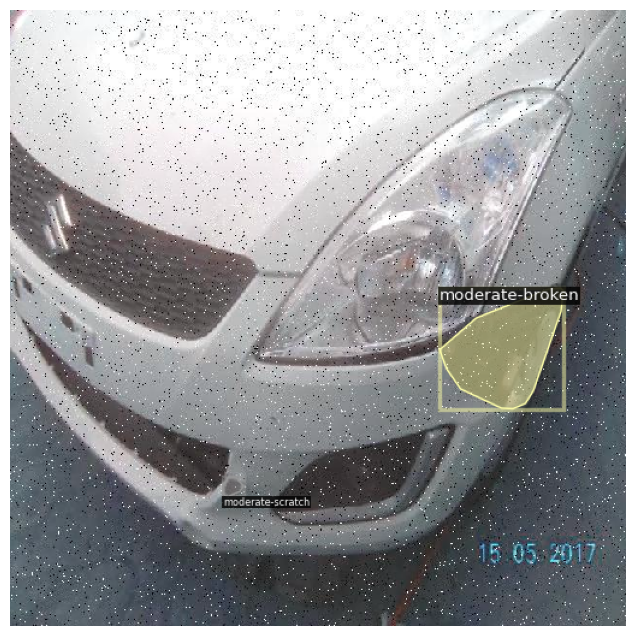

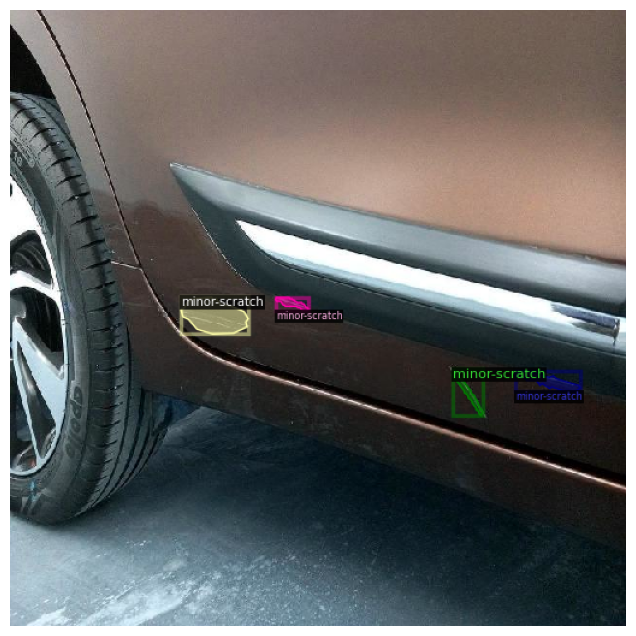

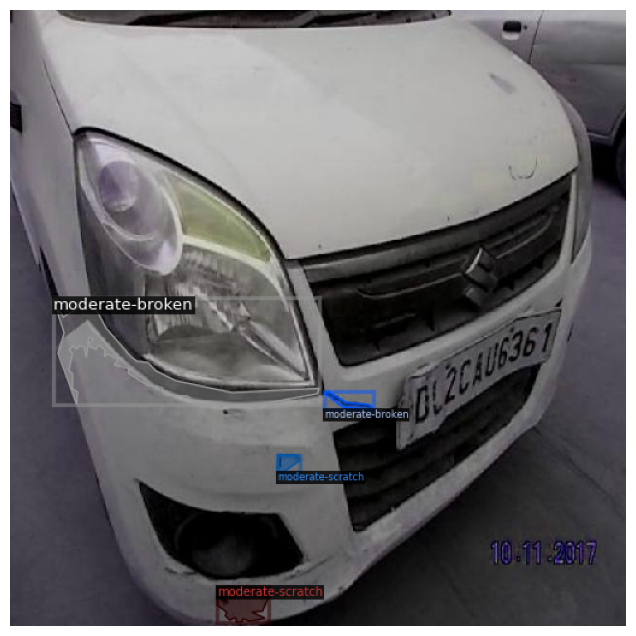

In [12]:
''
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Get the dataset metadata and dataset dicts
dataset_dicts = DatasetCatalog.get("severity-test")
metadata = MetadataCatalog.get("severity-test")

# Plot a few random images from the dataset
for d in random.sample(dataset_dicts, 3):  # Change the number to print more or fewer images
    img = cv2.imread(d["file_name"])

    # Create a visualizer and draw annotations (bounding boxes, etc.)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Display the image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

Testar uma imagem qualquer

In [20]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

# Configurações para o modelo treinado
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Threshold para a detecção
cfg.DATASETS.TEST = ("car-damage-s4-test",)  # Dataset de teste (opcional)

# Inicializa o preditor
predictor = DefaultPredictor(cfg)

# Carregar a imagem aleatória fora do dataset
image_path = "./datasets/car-damage-v8/valid/img0269_jpg.rf.8346f9565321d6b049a68188d2e2e2c7.jpg"  # Substitua com o caminho da imagem que você deseja testar
im = cv2.imread(image_path)


# Fazer a inferência
outputs = predictor(im)

if len(outputs["instances"]) > 0:
    v = Visualizer(im[:, :, ::-1], scale=1.2, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Mostrar a imagem com as previsões
    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
else:
    print("Nenhuma previsão foi detectada.")

[12/09 12:54:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (5, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (16, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (16,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (4, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) 

Nenhuma previsão foi detectada.
